## Objetivos 2:

- Estimar un modelo de regresión lineal que realice predicciones para el precio por metro cuadrado.
- Usar cross-validation para validar el modelo. Deberá prestar cierta atención a la estructura espacial de los precios.
- Aplicar regularización a modelos lineales pueden hacerlo para obtener un puntaje adicional. La idea es la siguiente: estimar una regresión ridge y una LASSO sobre el dataset. Para ello deberán usar cross-validation para tunear el parámetro de regularización que maximiza R2 en tu test set. 
  - ¿Cómo son las performances entre los modelos regularizados y no regularizado? 
  - ¿Cuál funciona mejor? ¿Qué “hace” una regresión ridge? 
  - ¿Y una LASSO? 
  - ¿Qué diferencias hay con la regresión lineal sin regularizar?
- Seleccionar mediante muestreo aleatorio simple una submuestra de 100 propiedades. Este será su portafolio de departamentos. En base al mejor modelo que haya encontrado determine cuáles de los departamentos, tanto en su portafolio como fuera de él, se encuentran sobrevaluados o subvaluados y en qué magnitud.
- Teniendo en cuenta que podría comprar y vender propiedades al precio de mercado, omitamos costos de transacción, con un capital inicial igual al valor de mercado de las propiedades en su portafolio. ¿Cuál es el mejor portafolio de propiedades que podría comprar?
  - Utilizar el modelo para ver cuales son las propiedades subvaluadas con respecto al precio tasado por el modelo, entendiendo que el modelo funciona correctamente.


In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from IPython.display import display

In [2]:
#Importamos la base de datos
properati = pd.read_csv("properati_Tasado_Lineal.csv")

In [3]:
#Test de tasado lineal
properati.shape
Target = properati[["price_usd_per_m2"]]
Features = properati.drop(columns=["price_usd_per_m2","Unnamed: 0","state_name","description","title"])

In [4]:
# Generamos una función que resume los coeficientes, el intercepto y el R2
# "model" = objeto con el modelo
# "X" = matrix de variables independientes

def sum_mod(model, X):
    a = pd.DataFrame(model.coef_ , X.columns.values)
    a = a.append(pd.DataFrame([model.intercept_, model.score(X, y)], index=['Intecept','R2']))
    return(a)

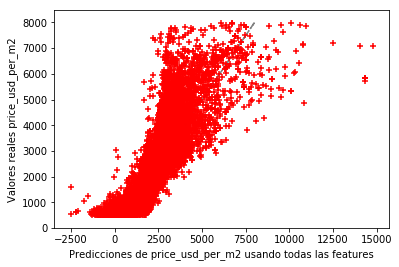

EMC: 315099.77205561555


In [5]:
lm = linear_model.LinearRegression()

X = Features
y = Target[["price_usd_per_m2"]]

model = lm.fit(X, y)
predictions = model.predict(X)

# Graficamos el modelo
plt.plot(y,y, '-.',c='grey')
plt.scatter(predictions, y, s=30, c='r', marker='+', zorder=10)
plt.xlabel("Predicciones de price_usd_per_m2 usando todas las features")
plt.ylabel("Valores reales price_usd_per_m2")
plt.show()
print ("EMC:", mean_squared_error(y, predictions))
prevMSE = mean_squared_error(y, predictions)


In [9]:
print ('Intercepto =', model.intercept_)
print ('RM = ', model.coef_)
print ('R2_train =', model.score(X, y))

Intercepto = [1228.8668086]
RM =  [[-2.55454414e-04 -2.68409537e+04  4.73595211e+05 -4.02644244e+00
  -2.67206540e+00  3.54757911e-02 -2.85091339e+02  2.30970317e+02
  -1.58307629e+02  2.12428651e+02 -6.01465170e+02  6.01465170e+02]]
R2_train = 0.6865856181796718


In [8]:
Features.columns

Index(['price', 'price_aprox_local_currency', 'price_aprox_usd',
       'surface_total_in_m2', 'surface_covered_in_m2', 'price_per_m2',
       'prop_type_PH', 'prop_type_apartment', 'prop_type_house',
       'prop_type_store', 'curr_ARS', 'curr_USD'],
      dtype='object')